### Names
* Youssef Said Ibrahim Rabie, 2, 40
* Ahmed Fawzy, 1, 7 

In [1]:
%pip install visual-automata===1.1.1


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Fixing minor bugs in the package used for visualizing the NFA
!PKG_PATH=$(pip --version | awk '{print $4}' | sed 's/pip//'); if ! grep -q "all_transitions = dict(all_transitions).deepcopy()" ${PKG_PATH}visual_automata/fa/nfa.py; then sed -i 's/all_transitions = all_transitions.deepcopy()/all_transitions = dict(all_transitions).deepcopy()/g' ${PKG_PATH}visual_automata/fa/nfa.py; fi
!PKG_PATH=$(pip --version | awk '{print $4}' | sed 's/pip//'); sed -i 's/\(for symbol, transitions in state_transitions.items():\)/\1\n                transitions=set(transitions)/' ${PKG_PATH}visual_automata/fa/nfa.py

# An ad-hoc solution to visualize partial DFAs
!PKG_PATH=$(pip --version | awk '{print $4}' | sed 's/pip//'); if ! grep -q "allow_partial: bool = False" ${PKG_PATH}visual_automata/fa/dfa.py; then sed -i 's/\(final_states: set = None\)/\1,\n        allow_partial: bool = False/' ${PKG_PATH}visual_automata/fa/dfa.py; sed -i 's/\(final_states=final_states,\)/\1\n                allow_partial=allow_partial/' ${PKG_PATH}visual_automata/fa/dfa.py; fi

### Imports

In [3]:
from typing import List, Tuple, Set
from dataclasses import dataclass
from enum import Enum
import json
from collections import OrderedDict, defaultdict
from visual_automata.fa.nfa import VisualNFA
from visual_automata.fa.dfa import VisualDFA
from IPython.display import display

### Definitions

In [4]:
opening_brackets = "(["
closing_brackets = ")]"
bracket_pairs = {')': '(', ']': '['}
quantifiers = ['*', '+', '?']
epsilon = "ε"

class OrderedSet:

    def __init__(self, elements=None):
        self.dict = OrderedDict()
        if elements is not None:
            for element in elements:
                self.add(element)

    def add(self, element):
        self.dict[element] = None

    def update(self, elements):
        for element in elements:
            self.add(element)

    def discard(self, element):
        self.dict.pop(element, None)

    def remove(self, element):
        try:
            del self.dict[element]
        except KeyError:
            raise KeyError(f"Element '{element}' not found in OrderedSet")

    def intersection(self, other):
        common_elements = (element for element in self if element in other)
        return OrderedSet(common_elements)

    def __contains__(self, element):
        return element in self.dict
    
    def __iter__(self):
        return iter(self.dict.keys())

    def __len__(self):
        return len(self.dict)
    
    def __repr__(self):
        return f"OrderedSet({list(self.dict.keys())})"

    def __set__(self):
        return set(self.dict.keys())

    def __getitem__(self, index):
        try:
            return list(self.dict.keys())[index]
        except IndexError:
            raise IndexError("Index out of range")

class ListOfSubExpressionsType(Enum):
    CONCATENATED = 1
    ORED = 2

@dataclass
class SubExpression:
    quantifier: str
    expression: str # This is the string expression if this SubExpression node is a leaf node.
    subtype: ListOfSubExpressionsType # This defines the relationship between the list of ListOfSubExpressions
    subexpression: List['ListOfSubExpressions']


@dataclass
class ListOfSubExpressions:
    ltype: ListOfSubExpressionsType # This defines the relationship between the list of SubExpressions
    llist: List['SubExpression']

class AutomatonType(Enum):
    NFA = 1
    DFA = 2

# Part 1

### Helper functions for string operations

In [5]:
# Check if the regex expression is valid or not
# Rules applied:
# 1. Unopened brackets/parentheses
# 2. No two consecutive quantifiers, unless the previous one is escaped, in which case it is treated literally. 
def check_if_valid(expression: str) -> bool:

    stack = []
    
    # Forbidden symbols at the beginning of the string
    if expression[0] in quantifiers: return False

    # Looping over the string
    for i in range(len(expression)):
        
        # Checking brackets are opened and closed properly
        if expression[i] in opening_brackets:
            stack.append(expression[i])
        elif expression[i] in closing_brackets:
            if not stack or stack.pop() != bracket_pairs[expression[i]]: return False
        
        # Checking that no invalid sequence of two consecutive quantifiers occur
        elif expression[i] in quantifiers:
            previous_quantifier = expression[i-1] in quantifiers
            if previous_quantifier:                
                if i-2 >= 0:
                    if expression[i-2] == '\\': continue 
                
                return False

    return not stack

# This function checks if a string ends with a certain character, with optional characters to ignore/discard when checking
def find_if_it_ends_with(string: str, char_to_find: str, chars_to_ignore: List[str], chars_not_to_ignore: List[str]) -> bool:
    
    for i in range(len(string)-1, -1, -1):
        
        # Default values for the lists in case one is not supplied
        if chars_to_ignore is None: chars_to_ignore = []
        if chars_not_to_ignore is None: chars_not_to_ignore = string 

        if (string[i] in chars_to_ignore) or (string[i] not in chars_not_to_ignore): continue
        elif string[i] == char_to_find: return True
        else: return False
    
    return False

# Check if a string is a parenthetical string, with optional quantifiers added to the end of it.
def check_if_parenthetical(string: str) -> bool:

    if string[0] != '(': return False
    return find_if_it_ends_with(string=string, char_to_find=')', chars_to_ignore=quantifiers, chars_not_to_ignore=None)

# Check if a string is a bracketed string, with optional quantifiers added to the end of it.
def check_if_bracketed(string: str) -> bool:

    if string[0] != '[': return False
    return find_if_it_ends_with(string=string, char_to_find=']', chars_to_ignore=quantifiers, chars_not_to_ignore=None)


### Splitting string expression into string subexpressions

In [6]:
# Split the string expression into string subexpressions valid to be subject to Thompson's Rule
def split_string_expression(expression: str) -> List[str]:
    
    sub_string_expressions = []
    brackets_stack = []
    current_sub_string_expression = ''

    for i in range(len(expression)):

        # Opening brackets MAY start a new sub-expression 
        if expression[i] in opening_brackets:
            
            # If we are not inside another set of brackets, then this is a new sub-expression
            if not brackets_stack:
                if current_sub_string_expression: sub_string_expressions.append(current_sub_string_expression)
                current_sub_string_expression = expression[i]
            
            # If we are, then it is not.
            else: current_sub_current_sub_string_expressionexpression += expression[i]

            brackets_stack.append(expression[i])
        
        # Literals start a new sub-expression if we are not inside a bracket/parenthesis
        elif (expression[i] not in quantifiers) and (expression[i] not in closing_brackets):
            
            if not brackets_stack:
                if current_sub_string_expression: sub_string_expressions.append(current_sub_string_expression)
                current_sub_string_expression = expression[i]
            else:
                current_sub_string_expression += expression[i]
        
        # Quantifiers and closing brackets do not start a new sub-expression
        else :
            current_sub_string_expression += expression[i]
            if expression[i] in closing_brackets: brackets_stack.pop()


    if current_sub_string_expression: sub_string_expressions.append(current_sub_string_expression)

    return sub_string_expressions

### Converting the string expression into a recursive SubExpression dataclass (tree)

In [7]:
# Returns tuple of (string of subexpression, quantifier)
def split_quantifier(sub_string_expression: str, is_bracketed: bool) -> Tuple[str, str]:
    
    quant_start_idx = len(sub_string_expression)

    for i in range(len(sub_string_expression)-1, -1, -1):
        if sub_string_expression[i] in quantifiers: quant_start_idx = i 
        else: break

    q = None if quant_start_idx == len(sub_string_expression) else sub_string_expression[quant_start_idx:]
    # Strip brackets and quantifiers
    s = sub_string_expression[1:quant_start_idx-1] if is_bracketed else sub_string_expression[0:quant_start_idx]

    return (s, q)

# Converts the string expression into a recursive SubExpression dataclass
def convert_to_subexpression(expression: str) -> SubExpression:

    def convert(subexpression_string: str) -> SubExpression:

        if check_if_parenthetical(subexpression_string):
            
            s, q = split_quantifier(sub_string_expression=subexpression_string, is_bracketed=True)

            substrings = split_string_expression(s)
            list_of_list_of_subexpressions = [list()]
            ored = False
        
            for substring in substrings:
                if substring == '|': 
                    ored = True
                    list_of_list_of_subexpressions.append(list())
                else:
                    list_of_list_of_subexpressions[len(list_of_list_of_subexpressions)-1].append(convert(substring))

            l = []
            for list_of_subexpressions in list_of_list_of_subexpressions:
                l.append(ListOfSubExpressions(ltype=ListOfSubExpressionsType.CONCATENATED, llist=list_of_subexpressions))

            return SubExpression(quantifier=q, expression=None, 
                                subexpression=l, subtype=ListOfSubExpressionsType(ored+1))

        # Base case
        else:
            s, q = split_quantifier(sub_string_expression=subexpression_string, is_bracketed=False) 
            if check_if_bracketed(s): s = s[1:len(s)-1]
            return SubExpression(quantifier=q, expression=s, subexpression=None, subtype=ListOfSubExpressionsType.CONCATENATED)

    
    if not check_if_valid(expression): return None

    substrings = split_string_expression(expression)
    subexpressions = []

    for substring in substrings: subexpressions.append(convert(substring))
    l = ListOfSubExpressions(ltype=ListOfSubExpressionsType.CONCATENATED, llist=subexpressions)
    
    # Root SubExpression node, with a quantifier of None, and subexpression = the list above
    return SubExpression(quantifier=None, expression=None, subexpression=[l], subtype=ListOfSubExpressionsType.CONCATENATED)

### Converting the SubExpression dataclass tree to a json/dict NFA

In [8]:
def rename_states(fa: OrderedDict) -> OrderedDict:

    # This function takes a FA, and renames its states with ascending numbers according to the order of states
    renamed_symbols = {}
    i = 0

    for key in fa.keys():
        if key == "startingState": continue
        renamed_symbols[key] = f"X{i}"
        i += 1 
    
    renamed_fa = str(fa)
    for old_symbol, new_symbol in renamed_symbols.items(): renamed_fa = renamed_fa.replace(f"'{old_symbol}'", f"'{new_symbol}'")
    renamed_fa = renamed_fa.replace("X", "S")

    return OrderedDict(eval(renamed_fa))

def add_transition(nfa: OrderedDict, source_state: str, input_symbol: str, dest_states: List[str]):

    # Adds a transition from the source state in the NFA on input_symbol to the destination states in dest_states
    if input_symbol in nfa[source_state]: nfa[source_state][input_symbol] += dest_states
    else: nfa[source_state][input_symbol] = dest_states

# 
def combine_subnfas(list_of_subnfas: List[OrderedDict], type: ListOfSubExpressionsType, counter: int) -> (OrderedDict, int):

    combined_nfa = OrderedDict()
    if type == ListOfSubExpressionsType.CONCATENATED:
        
        for i in range(len(list_of_subnfas)):
            list_of_keys = list(list_of_subnfas[i].keys())
            
            # Delete the startingState key in all SubExpressions except the first one
            if i != 0: del list_of_subnfas[i]["startingState"]

            # If this is not the last one, make its final state not a terminating state,
            # and add an edge from it to the starting state of the next SubExpression on ε input 
            if i != len(list_of_subnfas) - 1:
                
                terminating_states = []
                for state in list_of_subnfas[i]:
                    if state == "startingState": continue
                    if list_of_subnfas[i][state]["isTerminatingState"]:
                        list_of_subnfas[i][state]["isTerminatingState"] = False
                        terminating_states.append(state) 
                
                for terminating_state in terminating_states: 
                    add_transition(nfa=list_of_subnfas[i], source_state=terminating_state, input_symbol=epsilon, dest_states=[list_of_subnfas[i+1]["startingState"]])

            combined_nfa.update(list_of_subnfas[i])

    else:

        starting_state = f"S{counter+1}"
        combined_nfa["startingState"] = starting_state
        combined_nfa[starting_state] = {
            "isTerminatingState": False
        }
        counter += 1
        
        terminating_state = f"S{counter+1}"
        combined_nfa[terminating_state] = {
            "isTerminatingState": True
        }
        counter += 1

        prev_starting_states = []
        for i in range(len(list_of_subnfas)):
            
            list_of_keys = list(list_of_subnfas[i].keys())
            
            # Get the terminating states, and change them to be non-terminating
            for key in list_of_keys:
                if key == "startingState": continue
                
                if list_of_subnfas[i][key]["isTerminatingState"]:
                    list_of_subnfas[i][key]["isTerminatingState"] = False
                    add_transition(nfa=list_of_subnfas[i], source_state=key, input_symbol=epsilon, dest_states=[terminating_state])

            # Get the starting states and append them to the list
            prev_starting_states.append(list_of_subnfas[i]["startingState"])

            del list_of_subnfas[i]["startingState"]

            combined_nfa.update(list_of_subnfas[i])

        add_transition(nfa=combined_nfa, source_state=starting_state, input_symbol=epsilon, dest_states=prev_starting_states)

    return (combined_nfa, counter)

In [9]:
def handle_quantifier_logic_thompson(sub_nfa: OrderedDict, counter: int, quantifier: str) -> (OrderedDict, int):

    sub_nfa_copy = sub_nfa.deepcopy()
    quantified_nfa = OrderedDict()

    if quantifier in ["*", "+"]:
        
        # Inserting the new starting state
        starting_state = f"S{counter+1}"
        quantified_nfa["startingState"] = starting_state
        quantified_nfa[starting_state] = {
            "isTerminatingState": False
        }
        counter += 1
        
        terminating_state = f"S{counter+1}"
        counter += 1

        # Deleting the previous startingState key
        # Inserting the appropriate edges from the new starting state on ε input
        prev_starting_state = sub_nfa_copy["startingState"]
        del sub_nfa_copy ["startingState"]

        add_transition(nfa=quantified_nfa, source_state=starting_state, input_symbol=epsilon, dest_states=[prev_starting_state])
        if quantifier == "*":
            add_transition(nfa=quantified_nfa, source_state=starting_state, input_symbol=epsilon, dest_states=[terminating_state]) 

        # The previous terminating states are no longer terminating
        # Inserting the appropriate edges from the previous terminating states on ε input
        for key in sub_nfa_copy.keys():
            if key == "startingState": continue
            if sub_nfa_copy[key]["isTerminatingState"]:
                add_transition(nfa=sub_nfa_copy, source_state=key, input_symbol=epsilon, dest_states=[starting_state, terminating_state])
                sub_nfa_copy[key]["isTerminatingState"] = False

        # Inserting the updated states of d
        quantified_nfa.update(sub_nfa_copy)
        
        # Inserting the terminating state (this has to be done here to preserve
        # the order of key insertion)
        quantified_nfa[terminating_state] = {
            "isTerminatingState": True
        }
    elif quantifier == "?":
        
        terminating_states = []
        for state in sub_nfa_copy.keys():
            if state == "startingState": continue
            if sub_nfa_copy[state]["isTerminatingState"]: terminating_states.append(state)

        starting_state = sub_nfa_copy["startingState"]
        quantified_nfa.update(sub_nfa_copy)
        add_transition(nfa=quantified_nfa, source_state=starting_state, input_symbol=epsilon, dest_states=terminating_states)
            
    else:
        quantified_nfa.update(sub_nfa_copy)
    
    return (quantified_nfa, counter)


def convert_to_nfa(subexpression: SubExpression, counter: int) -> (OrderedDict, int):
        
    # Base case
    if subexpression.subexpression is None:
        
        sub_nfa = OrderedDict({
            "startingState": f"S{counter+1}",
            f"S{counter+1}": {
                "isTerminatingState": False,
                f"{subexpression.expression}": [f"S{counter+2}"]
            },
            f"S{counter+2}": {
                "isTerminatingState": True
            }
        })
        counter += 2
        nfa, counter = handle_quantifier_logic_thompson(sub_nfa=sub_nfa, counter=counter, quantifier=subexpression.quantifier)
    else:
    
        list_of_combined_subnfas = []

        for l in subexpression.subexpression:

            list_of_subnfas = []
            for s in l.llist:
                d, counter = convert_to_nfa(s, counter)
                list_of_subnfas.append(d)

            combined_subnfa, counter = combine_subnfas(list_of_subnfas, l.ltype, counter)
            list_of_combined_subnfas.append(combined_subnfa)
        
        sub_nfa, counter = combine_subnfas(list_of_combined_subnfas, subexpression.subtype, counter)
        nfa, counter = handle_quantifier_logic_thompson(sub_nfa=sub_nfa, counter=counter, quantifier=subexpression.quantifier)

    return (nfa, counter)

### Converting string regex expression to an NFA

In [10]:
def convert(expression: str) -> OrderedDict:
    subexpression = convert_to_subexpression(expression)
    nfa = rename_states(convert_to_nfa(subexpression, -1)[0])
    return nfa

### Visualization function

In [11]:
def visualize(
    fa: OrderedDict, 
    type: AutomatonType,
    allow_partial: bool = False
):

    copied_fa = fa.deepcopy()

    states = set(copied_fa.keys())
    states.remove("startingState")

    terminating_states = get_terminating_states(fa=fa)
    input_symbols = get_input_symbols(fa=fa)

    for key in copied_fa.keys():
        if key == "startingState": continue
        del copied_fa[key]["isTerminatingState"]

        for input_symbol in copied_fa[key].keys():

            if not isinstance(copied_fa[key][input_symbol], list):
                copied_fa[key][input_symbol] = copied_fa[key][input_symbol]
            else:
                copied_fa[key][input_symbol] = set(copied_fa[key][input_symbol])
    
    del copied_fa["startingState"]

    if type == AutomatonType.NFA:
        visual_fa = VisualNFA(
            states=states,
            input_symbols=set(input_symbols),
            transitions=dict(copied_fa),
            initial_state=fa["startingState"],
            final_states=set(terminating_states),
        )
    else:
        visual_fa = VisualDFA(
            states=states,
            input_symbols=set(input_symbols),
            transitions=dict(copied_fa),
            initial_state=fa["startingState"],
            final_states=set(terminating_states),
            allow_partial=allow_partial
        )

    # Forcing the diagram to show by wrapping it in IPython.display.display
    display(visual_fa.show_diagram())

# Part 2

### Subset Construction Algorithm, and helper functions

In [12]:
def epsilon_closure(nfa: OrderedDict, states: Set) -> Set:

    closure, queue, processed = set(), set(), set()

    for state in states: queue.add(state)

    while queue:
        
        s = queue.pop()
        if s in processed: continue
        closure.add(s)
    
        try:
            epsilon_transitions = nfa[s][epsilon]
            closure.update(epsilon_transitions)
            queue.update(epsilon_transitions)
        except KeyError:
            pass

        processed.add(s)

    return closure

def get_terminating_states(fa: OrderedDict) -> OrderedSet:

    terminating_states = []
    for state in fa.keys():
        if state == "startingState": continue
        if fa[state]["isTerminatingState"]: terminating_states.append(state)

    return OrderedSet(terminating_states)

def get_input_symbols(fa: OrderedDict) -> OrderedSet:

    input_symbols = OrderedSet()
    for s in fa.keys():
        if s == "startingState": continue
        input_symbols.update(list(fa[s].keys()))

    input_symbols.remove("isTerminatingState")

    return input_symbols

def check_if_state_exists(fa: OrderedDict, state: Tuple) -> bool:

    state_as_set = set(state)
    for key in fa.keys():
        if state_as_set == set(key): return True

    return False

# Return the set from a list of sets that intersects with the given set elementS
# The set elementS can optionally contain 1 element, in which case we're simply
# checking for membership of an item in the set

# If there are multiple sets that intersect with the given set, we simply return
# the first. Our use case, either way, only happens to be that this given set will
# intersect only ever with 1 set from the list
def get_set_of_a_member(sets: List[Set], elementS: Set) -> Set:
    for s in sets:
        if s.intersection(elementS): return s

    return None

In [13]:
def subset_construction(nfa: OrderedDict) -> OrderedDict:

    starting_state = epsilon_closure(nfa=nfa, states=set([nfa["startingState"]]))
    terminating_states = get_terminating_states(fa=nfa)

    input_symbols = get_input_symbols(fa=nfa)
    input_symbols.discard(epsilon)

    dfa = OrderedDict({
        "startingState": tuple(starting_state)
    })

    # Set of states to process
    # Each DFA state is a set of previous NFA states
    queue = set()
    queue.add(tuple(starting_state))

    while queue:
        
        dfa_state = queue.pop()

        if check_if_state_exists(fa=dfa, state=dfa_state): continue
        else:
            dfa[dfa_state] = {
                "isTerminatingState": bool(set(dfa_state).intersection(terminating_states))
            }

        for input_symbol in input_symbols:
            
            target_dfa_state = set()

            for nfa_state in dfa_state:
                try:
                    s = nfa[nfa_state][input_symbol]
                    target_dfa_state.update(s)
                except KeyError:
                    continue
        
            target_dfa_state.update(epsilon_closure(nfa=nfa, states=target_dfa_state))
            target_dfa_state = tuple(target_dfa_state)
            queue.add(target_dfa_state)
            dfa[dfa_state][input_symbol] = target_dfa_state
    
    stringified_dfa = dfa.deepcopy()

    for state in dfa.keys():
        
        if state == "startingState":
            stringified_dfa["startingState"] = ','.join(sorted(list(dfa["startingState"])))
            continue

        state_string = ','.join(sorted([s for s in state]))
        #if state_string == "": state_string = "phi"
        stringified_dfa[state_string] = dfa[state]

        del stringified_dfa[state]

        for transition_input, transition_state in dfa[state].items():
            if transition_input == "isTerminatingState": continue

            destination_state = ','.join(sorted([s for s in transition_state]))
            #if destination_state == "": destination_state = "phi" 
            stringified_dfa[state_string][transition_input] = destination_state 


    return stringified_dfa

### DFA Minimization Algorithm 

In [14]:
def minimize_dfa(dfa: OrderedDict, eliminate_dead_states: bool = False) -> OrderedDict:

    minimized_dfa = dfa.deepcopy()
    input_symbols = get_input_symbols(fa=minimized_dfa)

    # First, elimintaing all inaccessible states
    # Inaccessible states: All those states which can never be reached from the initial state are called as inaccessible states.
    accessible_states_queue = set([destination_state for destination_state in dfa[dfa["startingState"]].values()] + [dfa["startingState"]])
    accessible_states_queue.remove(dfa[dfa["startingState"]]["isTerminatingState"])
    accessible_states = set()

    while accessible_states_queue:
        state  = accessible_states_queue.pop()
        for destination_state in dfa[state].values():
            if not isinstance(destination_state, str): continue
            if state not in accessible_states: accessible_states_queue.add(destination_state)
        accessible_states.add(state)

    # Remove inaccessible states
    inaccessible_states = set(dfa.keys())
    inaccessible_states.remove("startingState")
    inaccessible_states.difference_update(accessible_states) 
    for inaccessible_state in inaccessible_states: del minimized_dfa[inaccessible_state]

    if eliminate_dead_states:
        # Secondly, eliminating all dead states: all those non-final states 
        # which transit to itself for all input symbols in ∑
        dead_states = set()
        for state in minimized_dfa.keys():
            if state == "startingState": continue
            if len(set(minimized_dfa[state].values())) == 2 and not minimized_dfa[state]["isTerminatingState"] and minimized_dfa[state][input_symbols[0]] == state:
                dead_states.add(state)

        for dead_state in dead_states: del minimized_dfa[dead_state]

        for state in minimized_dfa.keys():
            if state == "startingState": continue
            for input_symbol in input_symbols:
                if minimized_dfa[state][input_symbol] in dead_states:del minimized_dfa[state][input_symbol]

    # Then grouping and combining states
    terminating_states = get_terminating_states(fa=minimized_dfa)
    other_states = set(minimized_dfa.keys())
    other_states.difference_update(terminating_states)
    other_states.remove("startingState")
    
    groups = [other_states, terminating_states]
    queue = set([frozenset(other_states), frozenset(terminating_states)])

    while queue:

        group = queue.pop()

        if len(group) == 1: continue

        d = {state : dict() for state in group}
        for state in group:
            for input_symbol in input_symbols:
                d[state][input_symbol] = list(get_set_of_a_member(sets=groups, elementS=set([minimized_dfa[state][input_symbol]])))
        
        # reversed_d: keys are possible combinations of transitions, and the values are
        # the list of states that agree on that combination => those states stay within the
        # same group for the next iteration
        reversed_d = defaultdict(list)
        for state, transitions in d.items():
            reversed_d[json.dumps(transitions, sort_keys=True)].append(state)

        new_groups = groups.copy()
        for possible_new_group in reversed_d.values():

            p = set(possible_new_group)
            if p not in groups:
                
                # Get the old group (from the previous iteration) containing the states in p
                old_group = get_set_of_a_member(sets=groups, elementS=p)
                if old_group is not None:
                    if old_group in new_groups: new_groups.remove(old_group)
                    queue.discard(old_group)
                    new_groups.append(p)
                    queue.add(frozenset(p))

        groups = new_groups

    # If the number of groups is equal to the number of states
    # -1 because dfa has a key that is not a state: "startingState" key
    if len(groups) == len(dfa) - 1: return minimized_dfa

    for group in groups:
        
        if len(group) == 1: continue

        # Choosing the state to keep according to the following priorities:
        # 1. Start state
        # 2. Accepting state
        # 3. Transition from that state to another outsided on any input
        state_to_keep = None
        is_chosen_terminating_state = False
        for state in group:
            if state == dfa["startingState"]:
                state_to_keep = state
                break
            
            if (not is_chosen_terminating_state) and (state in terminating_states):
                state_to_keep = state
                is_chosen_terminating_state = True
                continue
            
            if state_to_keep is None:
                for input_symbol in input_symbols:
                    if dfa[state][input_symbol] not in group:
                        state_to_keep = state 
                        break
        
        group.difference_update(set([state_to_keep]))

        for discarded_state in group:
            
            del minimized_dfa[discarded_state]

            # Add an outgoing transition to ourselves if needed
            for input_symbol, destination_state in dfa[discarded_state].items():
                if destination_state == discarded_state:
                    minimized_dfa[state_to_keep][input_symbol] = state_to_keep

            # Updating ingoing transitions
            for state in dfa.keys():

                if state == "startingState": continue

                # If it is a discarded state, then there is no need to check the edges outgoing from
                # it to other discarded states
                if state not in minimized_dfa: continue

                for input_symbol, destination_state in dfa[state].items():
                    if destination_state == discarded_state:
                        minimized_dfa[state][input_symbol] = state_to_keep

    return minimized_dfa

### NFA and DFA test cases for the subset construction and DFA Minimization

In [15]:
####### NFAs
example_1 = OrderedDict({
    "startingState": "A",
    "A": {
        "isTerminatingState": False,
        epsilon: ["B", "H"],
    },
    "B": {
        "isTerminatingState": False,
        epsilon: ["C", "D"],
    },
    "C": {
        "isTerminatingState": False,
        "1": ["E"]
    },
    "D": {
        "isTerminatingState": False,
        "0": ["F"]
    },
    "E": {
        "isTerminatingState": False,
        epsilon: ["G"]
    },
    "F": {
        "isTerminatingState": False,
        epsilon: ["G"]
    },
    "G": {
        "isTerminatingState": False,
        epsilon: ["A", "H"]
    },
    "H": {
        "isTerminatingState": False,
        epsilon: ["I"]
    },
    "I": {
        "isTerminatingState": False,
        "1": ["J"]
    },
    "J": {
        "isTerminatingState": True
    }
})

example_2 = OrderedDict({
    "startingState": "q0",
    "q0": {
        "isTerminatingState": False,
        "a": ['q0'],
        "b": ["q0", "q1"]
    },
    "q1": {
        "isTerminatingState": False,
        "b": ["q2"]
    },
    "q2": {
        "isTerminatingState": True
    }
})

example_3 = OrderedDict({
    "startingState": "q0",
    "q0": {
        "isTerminatingState": False,
        "0": ["q0"],
        "1": ["q1", "q2"]
    },
    "q1": {
        "isTerminatingState": False,
        "0": ["q1", "q2"],
        "1": ["q2"]
    },
    "q2": {
        "isTerminatingState": True,
        "0": ["q0", "q1"],
        "1": ["q1"]
    }
})

example_4 = OrderedDict({
    "startingState": "q0",
    "q0": {
        "isTerminatingState": False,
        "a": ["q1", "q2"],
    },
    "q1": {
        "isTerminatingState": False
    },
    "q2": {
        "isTerminatingState": True,
        "a": ["q1", "q2"],
        "b": ["q2"]
    }
})

example_5 = OrderedDict({
    "startingState": "q0",
    "q0": {
        "isTerminatingState": False,
        "0": ["q0"],
        "1": ["q0", "q1"]
    },
    "q1": {
        "isTerminatingState": False,
        "0": ["q2"],
    },
    "q2": {
        "isTerminatingState": True,
    }
})

####### DFAs

# example from the slides
example_6 = OrderedDict({
    "startingState": "A",
    "A": {
        "isTerminatingState": False,
        "a": "B",
        "b": "C"
    },
    "B": {
        "isTerminatingState": False,
        "a": "B",
        "b": "D"
    },
    "C": {
        "isTerminatingState": False,
        "a": "B",
        "b": "C"
    },
    "D": {
        "isTerminatingState": False,
        "a": "B",
        "b": "E"
    },
    "E": {
        "isTerminatingState": True,
        "a": "B",
        "b": "C" 
    }
})

example_7 = OrderedDict({
    "startingState": "q0",
    "q0": {
        "isTerminatingState": False,
        "a": "q1",
        "b": "q2"
    },
    "q1": {
        "isTerminatingState": False,
        "a": "q1",
        "b": "q3"
    },
    "q2": {
        "isTerminatingState": False,
        "a": "q1",
        "b": "q2"
    },
    "q3": {
        "isTerminatingState": False,
        "a": "q1",
        "b": "q4"
    },
    "q4": {
        "isTerminatingState": True,
        "a": "q1",
        "b": "q2"
    }
})

example_8 = OrderedDict({
    "startingState": "q0",
    "q0": {
        "isTerminatingState": False,
        "a": "q1",
        "b": "q0"
    },
    "q1": {
        "isTerminatingState": True,
        "a": "q2",
        "b": "q1"
    },
    "q2": {
        "isTerminatingState": True,
        "a": "q1",
        "b": "q2"
    },
    "q3": {
        "isTerminatingState": False,
        "a": "q1",
        "b": "q2"
    }
})

example_9 = OrderedDict({
    "startingState": "q0",
    "q0": {
        "isTerminatingState": False,
        "0": "q1",
        "1": "q2"
    },
    "q1": {
        "isTerminatingState": False,
        "0": "q2",
        "1": "q3"
    },
    "q2": {
        "isTerminatingState": False,
        "0": "q2",
        "1": "q4"
    },
    "q3": {
        "isTerminatingState": True,
        "0": "q3",
        "1": "q3"
    },
    "q4": {
        "isTerminatingState": True,
        "0": "q4",
        "1": "q4"
    },
    "q5": {
        "isTerminatingState": False,
        "0": "q5",
        "1": "q4"
    }
})
example_10 = OrderedDict({
    "startingState": "q0",
    "q0": {
        "isTerminatingState": False,
        "0": "q3",
        "1": "q1"
    },
    "q1": {
        "isTerminatingState": True,
        "0": "q2",
        "1": "q5"
    },
    "q2": {
        "isTerminatingState": True,
        "0": "q2",
        "1": "q5"
    },
    "q3": {
        "isTerminatingState": False,
        "0": "q0",
        "1": "q4"
    },
    "q4": {
        "isTerminatingState": True,
        "0": "q2",
        "1": "q5"
    },
    "q5": {
        "isTerminatingState": False,
        "0": "q5",
        "1": "q5"
    }
})

### Main entrypoint code

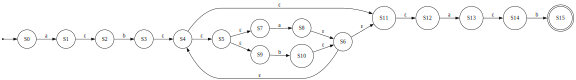

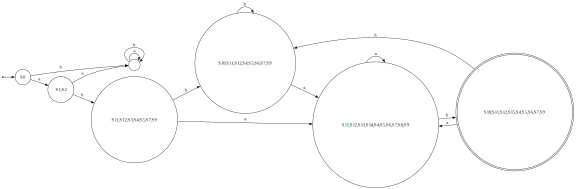

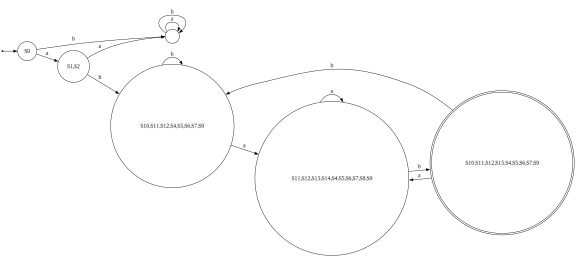

In [23]:
nfa = convert("ab(a|b)*ab")
visualize(fa=nfa, type=AutomatonType.NFA)

dfa = subset_construction(nfa=nfa)
visualize(fa=dfa, type=AutomatonType.DFA, allow_partial=True)

minimized_dfa = minimize_dfa(dfa)
visualize(fa=minimized_dfa, type=AutomatonType.DFA, allow_partial=True)